In [19]:
import tensorflow as tf

# (optional but recommended) GPU memory growth
gpus = tf.config.list_physical_devices("GPU")
for g in gpus:
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception as e:
        print("Could not set memory growth for", g, ":", e)

print("TF version:", tf.__version__)
print("GPUs:", gpus)

import json
from pathlib import Path

import numpy as np
import pandas as pd
keras = tf.keras
from keras import layers, models

TF version: 2.16.1
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [20]:
# EDIT this to where your splits.json lives
SPLITS_FILE = Path('splits.json')
BASE_DIR = SPLITS_FILE.parent

print("SPLITS_FILE:", SPLITS_FILE)
print("BASE_DIR   :", BASE_DIR)
print("Exists? splits:", SPLITS_FILE.exists(), "  base:", BASE_DIR.exists())


SPLITS_FILE: splits.json
BASE_DIR   : .
Exists? splits: True   base: True


### Load splits.json & build a DataFrame

In [21]:
with open(SPLITS_FILE, "r") as f:
    splits = json.load(f)
print("Keys in splits:", list(splits.keys()))
for k in splits:
    print(k, ":", len(splits[k]), "images")
    for i in range(len(splits[k])):
        splits[k][i] = splits[k][i].replace("\\", "/")
rows = []
for split_name, rel_paths in splits.items():
    for rel in rel_paths:
        rel_path = Path(rel)
        img_path = BASE_DIR / rel_path
        cls = img_path.parent.name
        rows.append({
            "split": split_name,
            "class_name": cls,
            "image_path": str(img_path),
        })

df = pd.DataFrame(rows)
df["split"].value_counts(), df["class_name"].value_counts()


Keys in splits: ['train', 'val', 'test']
train : 839 images
val : 180 images
test : 181 images


(split
 train    839
 test     181
 val      180
 Name: count, dtype: int64,
 class_name
 Corals          200
 Ammonites       200
 Belemnites      200
 Crinoids        200
 Leaf fossils    200
 Trilobites      200
 Name: count, dtype: int64)

### Label encoding & file lists per split

In [22]:
classes = sorted(df["class_name"].unique())
class_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_class = {i: c for c, i in class_to_idx.items()}

print("Classes:", classes)
print("Mapping:", class_to_idx)
def get_file_label_arrays(split_name):
    sub = df[df["split"] == split_name].copy()
    filepaths = sub["image_path"].values.astype(str)
    labels = sub["class_name"].map(class_to_idx).values.astype(np.int32)
    print(f"{split_name}: {len(filepaths)} images")
    return filepaths, labels

train_files, train_labels = get_file_label_arrays("train")
val_files,   val_labels   = get_file_label_arrays("val")
test_files,  test_labels  = get_file_label_arrays("test")

Classes: ['Ammonites', 'Belemnites', 'Corals', 'Crinoids', 'Leaf fossils', 'Trilobites']
Mapping: {'Ammonites': 0, 'Belemnites': 1, 'Corals': 2, 'Crinoids': 3, 'Leaf fossils': 4, 'Trilobites': 5}
train: 839 images
val: 180 images
test: 181 images


### tf.data loader (image → tensor)

In [23]:
IMG_SIZE = 224
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE

def load_and_preprocess(path, label):
    # path: scalar string tensor
    img_bytes = tf.io.read_file(path)
    # decode (handles JPEG/PNG)
    img = tf.io.decode_image(img_bytes, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img, label


### Build train/val/test datasets

In [24]:
def make_dataset(filepaths, labels, batch_size=BATCH_SIZE, training=False):
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    if training:
        ds = ds.shuffle(len(filepaths), reshuffle_each_iteration=True)
    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(train_files, train_labels, training=True)
val_ds   = make_dataset(val_files,   val_labels,   training=False)
test_ds  = make_dataset(test_files,  test_labels,  training=False)

train_ds, val_ds, test_ds


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

### Define a ResNet50 model in Keras (TensorFlow)

In [32]:
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
tf.config.optimizer.set_jit(False)
num_classes = len(classes)

data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation"
)

base_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    pooling="avg",  # global average pooling
)

base_model.trainable = False  # first train only the new head

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)          # ResNet preprocessing
x = base_model(x, training=False)

x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)

fine_tune_from = len(base_model.layers) // 2

for i, layer in enumerate(base_model.layers):
    layer.trainable = (i >= 0)
    
model = tf.keras.Model(inputs, outputs)
model.summary()


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer_13[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_12         │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_13         │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_14         │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_4 (Stack)     │ (None, 224, 224,  │          0 │ get_item_12[0][0… │
│                     │ 3)                │            │ get_item_13[0][0… │
│                     │                   │            │ get_item_14[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 224, 224,  │          0 │ stack_4[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2048)      │ 23,587,712 │ add_4[0][0]       │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 512)       │  1,049,088 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 512)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 128)       │     65,664 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128)       │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 6)         │        774 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,703,238 (94.24 MB)

 Trainable params: 24,650,118 (94.03 MB)

 Non-trainable params: 53,120 (207.50 KB)

### Compile & train (frozen backbone)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


print("Trainable layers:", sum(layer.trainable for layer in base_model.layers), "of", len(base_model.layers))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

RESULTS_DIR = Path("results/resnet50 training")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

checkpoint_path = RESULTS_DIR / "resnet50_geo_fossil_frozen_best.keras"

callbacks = [
    EarlyStopping(
        monitor="val_accuracy",
        patience=15,
        restore_best_weights=True,
        verbose=0,
    ),
    ModelCheckpoint(
        filepath=str(checkpoint_path),
        monitor="val_accuracy",
        save_best_only=True,
        verbose=0,
    ),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    callbacks=callbacks,
)


Trainable layers: 176 of 176
Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.1916 - loss: 2.2646 - val_accuracy: 0.1667 - val_loss: 2.2668
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.2300 - loss: 1.9669 - val_accuracy: 0.1667 - val_loss: 2.2229
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.2935 - loss: 1.7579 - val_accuracy: 0.1667 - val_loss: 2.2233
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3765 - loss: 1.6120 - val_accuracy: 0.1667 - val_loss: 2.2122
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4374 - loss: 1.4574 - val_accuracy: 0.1667 - val_loss: 2.1998
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4702 - loss: 1.3493 - val_accuracy: 0.1667 - val_loss: 2.1987
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5408 - loss: 1.2484 - val_accuracy: 0.1667 - val_loss: 2.2003
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6054 - loss: 1.1264 - val_accurac

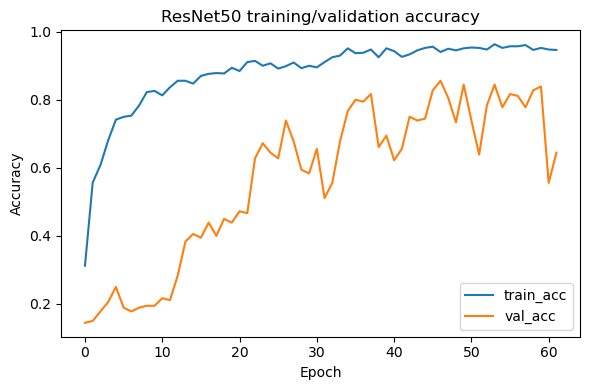

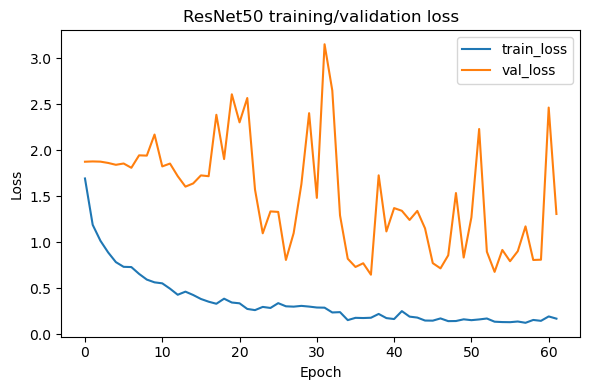

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("ResNet50 training/validation accuracy")
plt.tight_layout()
plt.savefig(RESULTS_DIR / "resnet50_acc.png", dpi=300, bbox_inches="tight")
plt.show()


# Loss
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("ResNet50 training/validation loss")
plt.tight_layout()
plt.savefig(RESULTS_DIR / "resnet50_loss.png", dpi=300, bbox_inches="tight")
plt.show()

### Evaluate on test set + confusion matrix

In [28]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 829ms/step - accuracy: 0.8160 - loss: 0.7859
Test accuracy: 0.8176795840263367


2025-12-03 07:05:10.444434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


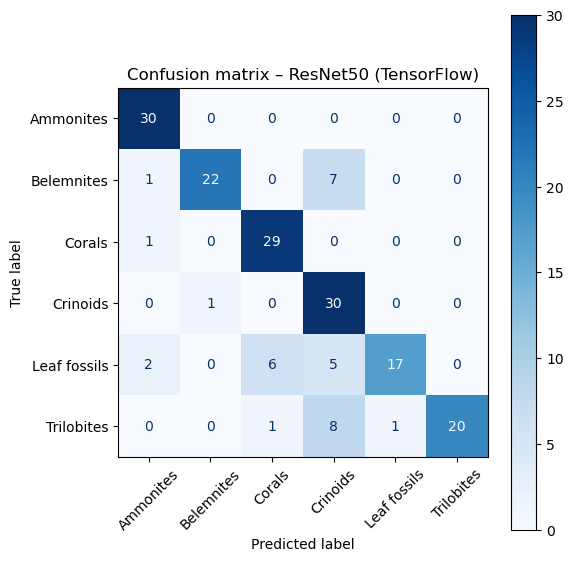

Saved confusion matrix to: results/resnet50 training/cm_resnet50_tf.png

Classification report:
              precision    recall  f1-score   support

   Ammonites      0.882     1.000     0.938        30
  Belemnites      0.957     0.733     0.830        30
      Corals      0.806     0.967     0.879        30
    Crinoids      0.600     0.968     0.741        31
Leaf fossils      0.944     0.567     0.708        30
  Trilobites      1.000     0.667     0.800        30

    accuracy                          0.818       181
   macro avg      0.865     0.817     0.816       181
weighted avg      0.863     0.818     0.816       181



In [29]:
# Get predictions and confusion matrix
y_true = []
y_pred = []

for batch_imgs, batch_labels in test_ds:
    preds = model.predict(batch_imgs, verbose=0)
    y_true.extend(batch_labels.numpy().tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

plt.figure(figsize=(6, 6))
disp.plot(include_values=True, cmap="Blues", ax=plt.gca(), xticks_rotation=45)
plt.title("Confusion matrix – ResNet50 (TensorFlow)")
plt.tight_layout()
cm_path = RESULTS_DIR / "cm_resnet50_tf.png"
plt.savefig(cm_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved confusion matrix to:", cm_path)
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=classes, digits=3))


In [30]:
# from tensorflow import keras
# model = keras.models.load_model("results/resnet50_geo_fossil_frozen_best.keras")
